In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ファイルパス（環境に応じて調整）
metadata_path = "../data/processed/paper_metadata.csv"
if not os.path.exists(metadata_path):
    raise FileNotFoundError(f"File not found: {metadata_path}")

# データ読み込み
df = pd.read_csv(metadata_path)
del df['Unnamed: 0']

In [2]:
# 任意の英語文字列をLlama3で日本語に翻訳するサンプル

# --- 方法①: LangChain の OllamaLLM を利用 ---
try:
    from langchain_ollama import OllamaLLM
    use_langchain = True
except ImportError:
    use_langchain = False

# --- 方法②: Ollama ローカル HTTP API を利用 ---
import requests

def translate_to_japanese(text: str) -> str:
    """
    英語の text を Llama3 で日本語に翻訳して返します。
    LangChainのOllamaLLMが使える場合はそちらを優先し、
    そうでなければ直接HTTP APIを呼び出します。
    """
    if use_langchain:
        # LangChain 経由
        llm = OllamaLLM(model="llama3")
        prompt = (
            "Translate the following English text into Japanese.\n"
            "Output only the Japanese translation, no extra text.\n\n"
            f"{text}\n"
            "Japanese:"
        )
        return llm(prompt).strip()
    else:
        # 直接HTTP API呼び出し
        api_url = "http://localhost:11434/api/completions"
        payload = {
            "model": "llama3",
            "prompt": (
                "Translate the following English text into Japanese.\n"
                "Output only the Japanese translation, no extra text.\n\n"
                f"{text}\n"
                "Japanese:"
            ),
            "max_tokens": 128,
            "temperature": 0.0
        }
        r = requests.post(api_url, json=payload, timeout=60)
        r.raise_for_status()
        return r.json()["choices"][0]["text"].strip()

# --- 使い方例 ---
if __name__ == "__main__":
    english_examples = [
        "Climate change increases the risk of malaria transmission.",
        "We conducted a systematic review of socioeconomic factors."
    ]
    for ex in english_examples:
        jp = translate_to_japanese(ex)
        print(f"EN: {ex}\nJP: {jp}\n")


C:\Users\user\AppData\Local\Temp\ipykernel_14036\4148900442.py:28: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  return llm(prompt).strip()


EN: Climate change increases the risk of malaria transmission.
JP: 気候変動はマラリアの伝染リスクを増加させる。

EN: We conducted a systematic review of socioeconomic factors.
JP: 社会経済的要因に関する体系的なレビューを行った。



## マニュアルな正規化

In [2]:
# 正規化関数
def normalize(term):
    t = term.lower().strip().replace('_',' ')
    # ies -> y
    if t.endswith('ies'):
        return t[:-3] + 'y'
    # sis は除外
    if t.endswith('sis'):
        return t
    # 一般的な複数形sを除去
    if t.endswith('s') and len(t) > 3:
        return t[:-1]
    return t

# data_typesの集計
data_items = []
for entry in df['data_types'].dropna():
    for part in entry.split(','):
        norm = normalize(part)
        if norm:
            data_items.append(norm)

data_counts = pd.Series(data_items).value_counts()

# methodsの集計
method_items = []
for entry in df['methods'].dropna():
    for part in entry.split(','):
        norm = normalize(part)
        if norm:
            method_items.append(norm)

method_counts = pd.Series(method_items).value_counts()

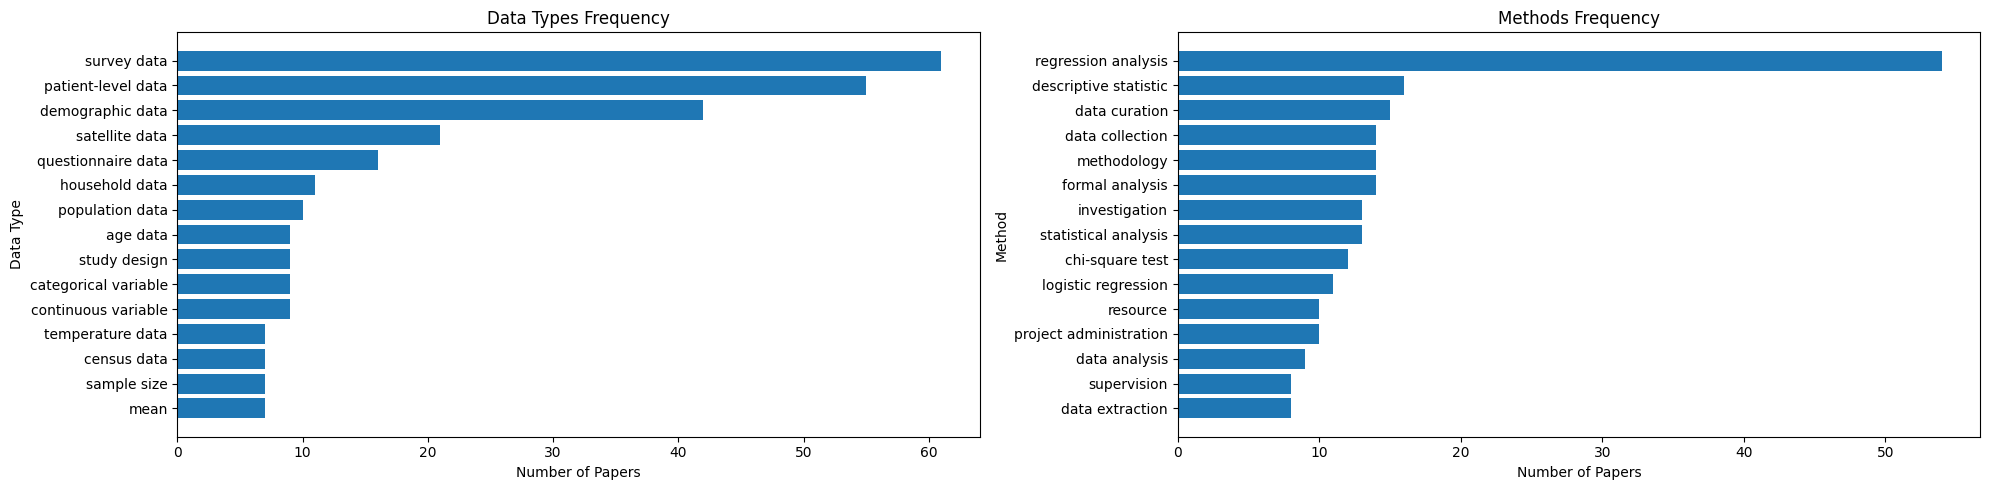

In [3]:
# 図を2列並べて作成
fig, axes = plt.subplots(ncols=2, figsize=(20, 5))

# 左: data_types
axes[0].barh(data_counts[0:15].index, data_counts[0:15].values)
axes[0].invert_yaxis()
axes[0].set_title("Data Types Frequency")
axes[0].set_xlabel("Number of Papers")
axes[0].set_ylabel("Data Type")

# 右: methods
axes[1].barh(method_counts[0:15].index, method_counts[0:15].values)
axes[1].invert_yaxis()
axes[1].set_title("Methods Frequency")
axes[1].set_xlabel("Number of Papers")
axes[1].set_ylabel("Method")

plt.tight_layout()
# plt.savefig('../imgs/frequency.png')
plt.show()

## NLTKを使う

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import nltk
from nltk.stem import WordNetLemmatizer

# nltkのWordNetを利用するためのダウンロード
nltk.download('wordnet')

# ファイルパス（環境に応じて調整）
metadata_path = "../data/processed/paper_metadata.csv"
if not os.path.exists(metadata_path):
    raise FileNotFoundError(f"File not found: {metadata_path}")

# データ読み込み
df = pd.read_csv(metadata_path)

# WordNetLemmatizerを初期化
lemmatizer = WordNetLemmatizer()

# 正規化関数：小文字化・空白除去・アンダースコア→空白・単数形化
def normalize(term: str) -> str:
    t = term.lower().strip().replace('_', ' ')
    # 各単語をWordNetで単数形に
    tokens = t.split()
    lemmatized = [lemmatizer.lemmatize(tok) for tok in tokens]
    return ' '.join(lemmatized)

# data_typesの集計
data_items = []
for entry in df['data_types'].dropna():
    for part in entry.split(','):
        norm = normalize(part)
        if norm:
            data_items.append(norm)

data_counts = pd.Series(data_items).value_counts()

# methodsの集計
method_items = []
for entry in df['methods'].dropna():
    for part in entry.split(','):
        norm = normalize(part)
        if norm:
            method_items.append(norm)

method_counts = pd.Series(method_items).value_counts()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
pd.DataFrame({
    'method':method_counts.index,
    'count': method_counts.values
}).to_csv('../data/metadata/method_ranking.csv', index=False, encoding='utf-8-sig')
pd.DataFrame({
    'data':data_counts.index,
    'count': data_counts.values
}).to_csv('../data/metadata/data_type_ranking.csv', index=False, encoding='utf-8-sig')

In [64]:
# method_counts_df = pd.read_csv('../data/metadata/method_ranking_modified.csv', encoding='utf-8-sig')
# data_counts_df = pd.read_csv('../data/metadata/data_type_ranking_modified.csv', encoding='utf-8-sig')

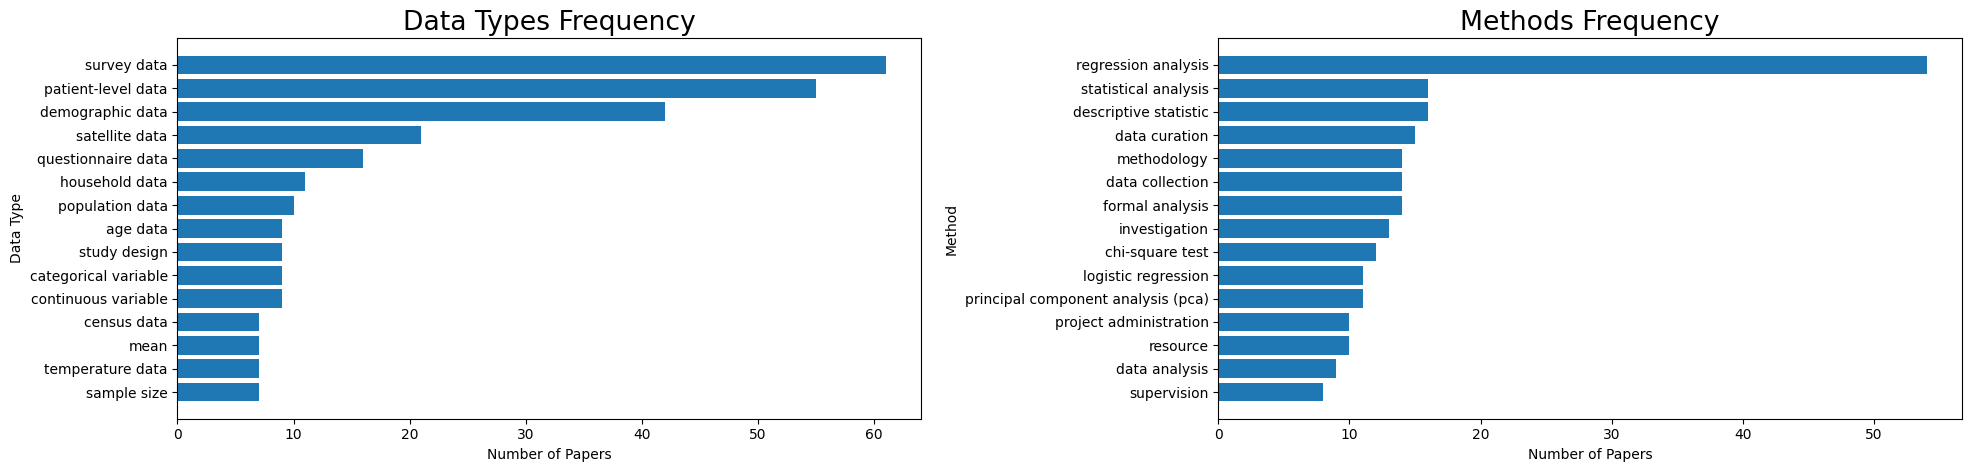

In [7]:
# 図を2列並べて作成
fig, axes = plt.subplots(ncols=2, figsize=(20, 5))
plt.rcParams['font.size']=16
# 左: data_types
axes[0].barh(data_counts[0:15].index, data_counts[0:15].values)
axes[0].invert_yaxis()
axes[0].set_title("Data Types Frequency")
axes[0].set_xlabel("Number of Papers")
axes[0].set_ylabel("Data Type")

# 右: methods
axes[1].barh(method_counts[0:15].index, method_counts[0:15].values)
axes[1].invert_yaxis()
axes[1].set_title("Methods Frequency")
axes[1].set_xlabel("Number of Papers")
axes[1].set_ylabel("Method")

plt.tight_layout()
plt.savefig('../imgs/frequency_en.png')
plt.show()

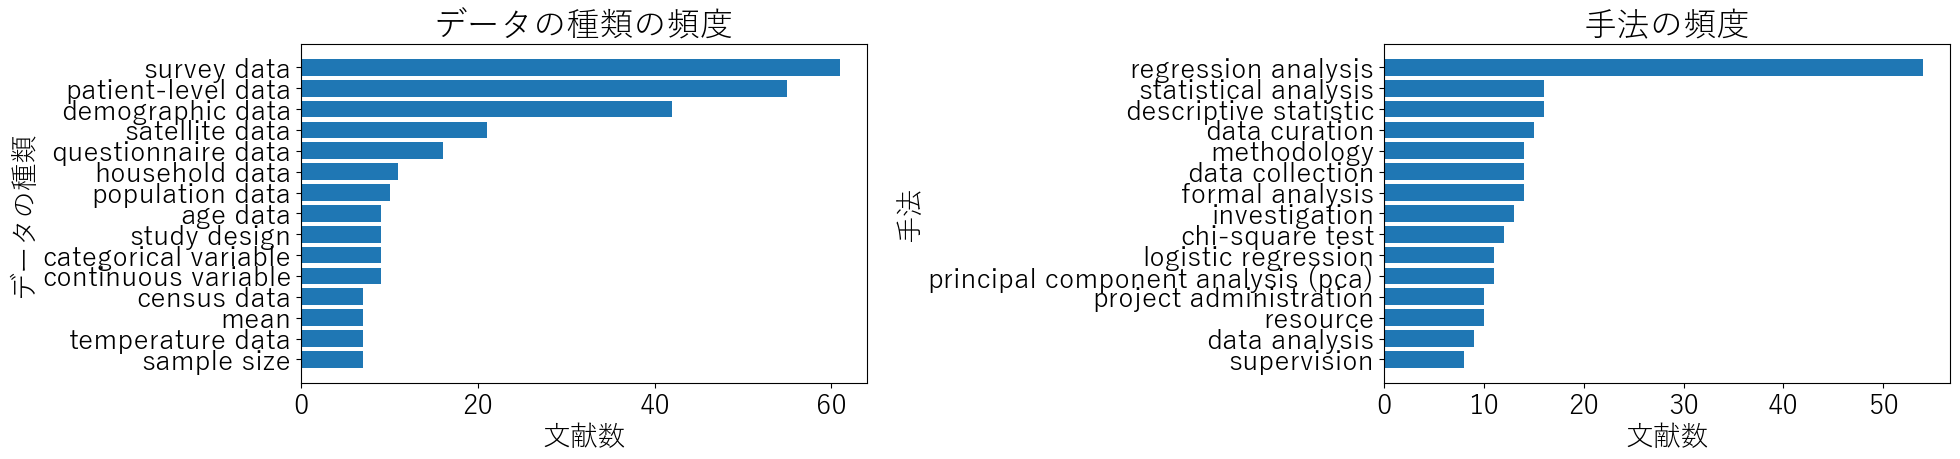

In [10]:
# 図を2列並べて作成
plt.rcParams['font.size']=20
plt.rcParams['font.family']='Yu Gothic'
# plt.rcParams['font.family']='IPAexGothic'

fig, axes = plt.subplots(ncols=2, figsize=(20, 5))
# 左: data_types
axes[0].barh(data_counts[0:15].index, data_counts[0:15].values)
axes[0].invert_yaxis()
axes[0].set_title("データの種類の頻度")
axes[0].set_xlabel("文献数")
axes[0].set_ylabel("データの種類")

# 右: methods
axes[1].barh(method_counts[0:15].index, method_counts[0:15].values)
axes[1].invert_yaxis()
axes[1].set_title("手法の頻度")
axes[1].set_xlabel("文献数")
axes[1].set_ylabel("手法")

plt.tight_layout()
plt.savefig('../imgs/frequency_jp.png')
plt.show()

In [14]:
jp_data_counts = ['サーベイデータ','患者データ','人口統計データ','衛星データ','アンケートデータ','世帯データ','人口データ',
                  '年齢データ','研究デザイン','カテゴリカル変数','連続変数','国勢調査データ','平均','気温データ','サンプルサイズ']
jp_method_counts = ['回帰分析','統計分析','記述統計','データキュレーション','方法論','データ収集','形式分析','調査','カイ二乗検定',
                    'ロジスティック回帰','主成分分析','プロジェクト管理','リソース','データ分析','訓練']

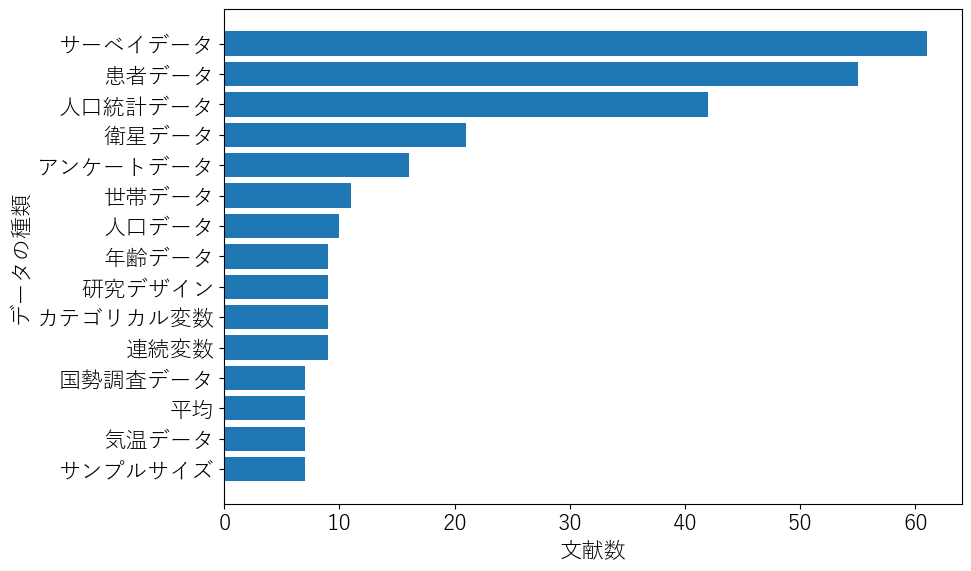

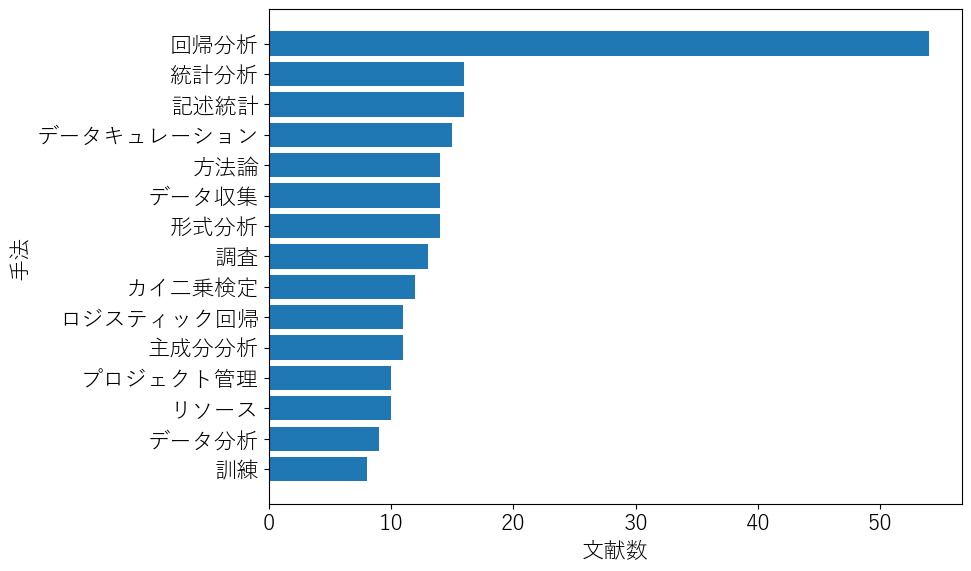

In [15]:
import os
import matplotlib.pyplot as plt

# 日本語フォント設定
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Yu Gothic'  # 環境に合わせて変更可能

# 保存先フォルダ
os.makedirs('../imgs', exist_ok=True)

# --- Data Types のプロット ---
fig = plt.figure(figsize=(10, 6))
plt.barh(jp_data_counts, data_counts[0:15].values)
plt.gca().invert_yaxis()
# plt.title("データの種類の頻度", fontsize=16)
plt.xlabel("文献数", fontsize=16)
plt.ylabel("データの種類", fontsize=16)
plt.tight_layout()
fig.savefig('../imgs/data_types_frequency_jp.png')
plt.show()

# --- Methods のプロット ---
fig = plt.figure(figsize=(10, 6))
plt.barh(jp_method_counts, method_counts[0:15].values)
plt.gca().invert_yaxis()
# plt.title("手法の頻度", fontsize=16)
plt.xlabel("文献数", fontsize=16)
plt.ylabel("手法", fontsize=16)
plt.tight_layout()
fig.savefig('../imgs/methods_frequency_jp.png')
plt.show()


## LLMを使用

In [41]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import csv
from tqdm import trange
from collections import Counter
from langchain_ollama import OllamaLLM

# ➊ normalize関数の定義
def normalize(term: str) -> str:
    t = term.lower().strip().replace('-', ' ').replace('_', ' ')
    # special common mapping
    if t == 'did':
        return 'difference in difference'
    # ies -> y
    if t.endswith('ies'):
        t = t[:-3] + 'y'
    # sis はそのまま（analysisなど）
    elif t.endswith('sis'):
        t = t
    # 単数形処理: 最後のsだけ落とす
    elif t.endswith('s') and len(t) > 3:
        t = t[:-1]
    return t
    
# 1. LLM 初期化
llm = OllamaLLM(model="llama3")

# 2. メタデータ読み込み
metadata_path = "../data/processed/paper_metadata.csv"
df = pd.read_csv(metadata_path)

# ➌ ターム抽出（Strip + 原文保持）
all_methods = []
for cell in df['methods'].dropna():
    for raw in str(cell).split(','):
        term = raw.strip()
        if term:
            all_methods.append(term)

unique_methods = list(dict.fromkeys(all_methods))

all_data = []
for cell in df['data_types'].dropna():
    for raw in str(cell).split(','):
        term = raw.strip()
        if term:
            all_data.append(term)

unique_data = list(dict.fromkeys(all_data))

In [49]:
# ➍ 動的正規化マップ構築
canonical = []
norm_map = {}

for i in trange(len(unique_methods)):
    term = unique_methods[i]
    clean = normalize(term)
    # もし先に同じnormalize後タームが代表リストにあればそれを流用
    if clean in canonical:
        norm_map[term] = clean
        continue

    mapped = None
    # 代表候補ごとにLLMに同一概念か問う
    for canon in canonical:
        prompt = (
            f"Do these refer to the same method concept? Answer 'yes' or 'no'.\n"
            f"Method A: {canon}\n"
            f"Method B: {clean}\n"
            f"Same concept?"
        )
        resp = llm(prompt).strip().lower()
        if "yes" in resp:
            mapped = canon
            break

    if mapped:
        norm_map[term] = mapped
    else:
        # 新たな代表として追加
        canonical.append(clean)
        norm_map[term] = clean

# ➎ マッピング後にカウント集計（get を使う）
from collections import Counter
normalized = [ norm_map.get(t.strip(), t.strip()) for t in all_methods ]
method_counts = Counter(normalized)

100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


In [ ]:
# ➍ 動的正規化マップ構築
canonical = []
norm_map = {}

for i in trange(len(unique_data)):
    term = unique_methods[i]
    clean = normalize(term)
    # もし先に同じnormalize後タームが代表リストにあればそれを流用
    if clean in canonical:
        norm_map[term] = clean
        continue

    mapped = None
    # 代表候補ごとにLLMに同一概念か問う
    for canon in canonical:
        prompt = (
            f"Do these refer to the same data type concept? Answer 'yes' or 'no'.\n"
            f"Method A: {canon}\n"
            f"Method B: {clean}\n"
            f"Same concept?"
        )
        resp = llm(prompt).strip().lower()
        if "yes" in resp:
            mapped = canon
            break

    if mapped:
        norm_map[term] = mapped
    else:
        # 新たな代表として追加
        canonical.append(clean)
        norm_map[term] = clean

# ➎ マッピング後にカウント集計（get を使う）
from collections import Counter
normalized = [ norm_map.get(t.strip(), t.strip()) for t in all_data ]
data_counts = Counter(normalized)

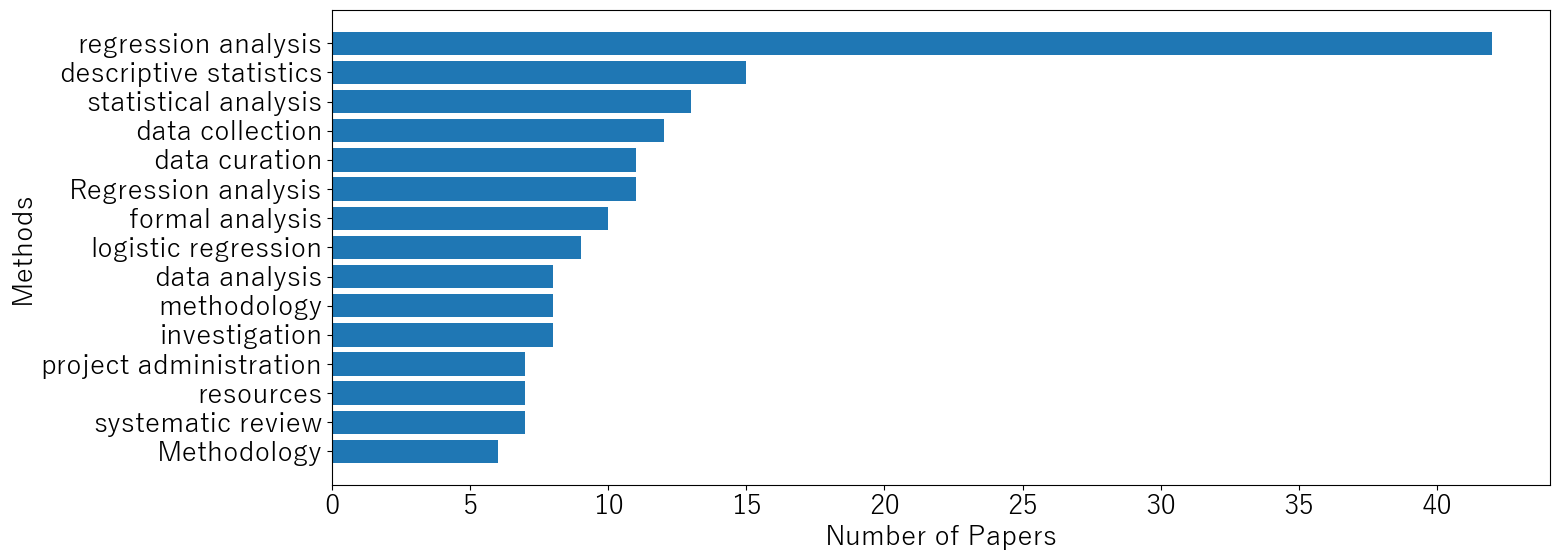

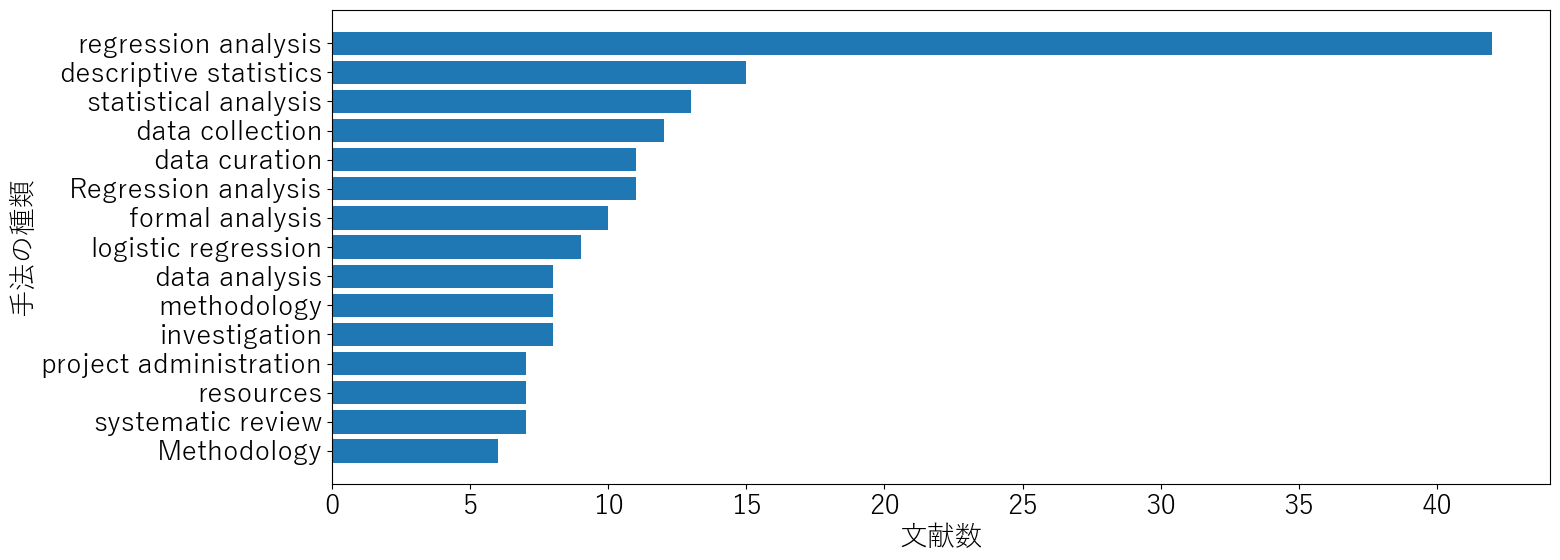

In [ ]:
# DataFrameに変換してランキング化
rank_df = pd.DataFrame(method_counts.items(), columns=['method', 'count'])
rank_df = rank_df.sort_values(by='count', ascending=False).reset_index(drop=True)
rank_df['rank'] = rank_df.index + 1

# 3. プロット
plt.rcParams['font.size']=20
plt.rcParams['font.family']='Yu Gothic'

plt.figure(figsize=(16, 6))
plt.barh(rank_df['method'][0:15], rank_df['count'][0:15])
plt.gca().invert_yaxis()
plt.xlabel('Number of Papers')
plt.ylabel('Methods')
plt.tight_layout()
plt.savefig('../imgs/llm_methods_ranking_en.png')
plt.show()

plt.figure(figsize=(16, 6))
plt.barh(rank_df['method'][0:15], rank_df['count'][0:15])
plt.gca().invert_yaxis()
plt.xlabel('文献数')
plt.ylabel('手法の種類')
plt.tight_layout()
plt.savefig('../imgs/llm_methods_ranking_jp.png')
plt.show()
# 4. 保存
rank_df.to_csv('../data/metadata/method_ranking.csv', index=False, encoding='utf-8-sig')

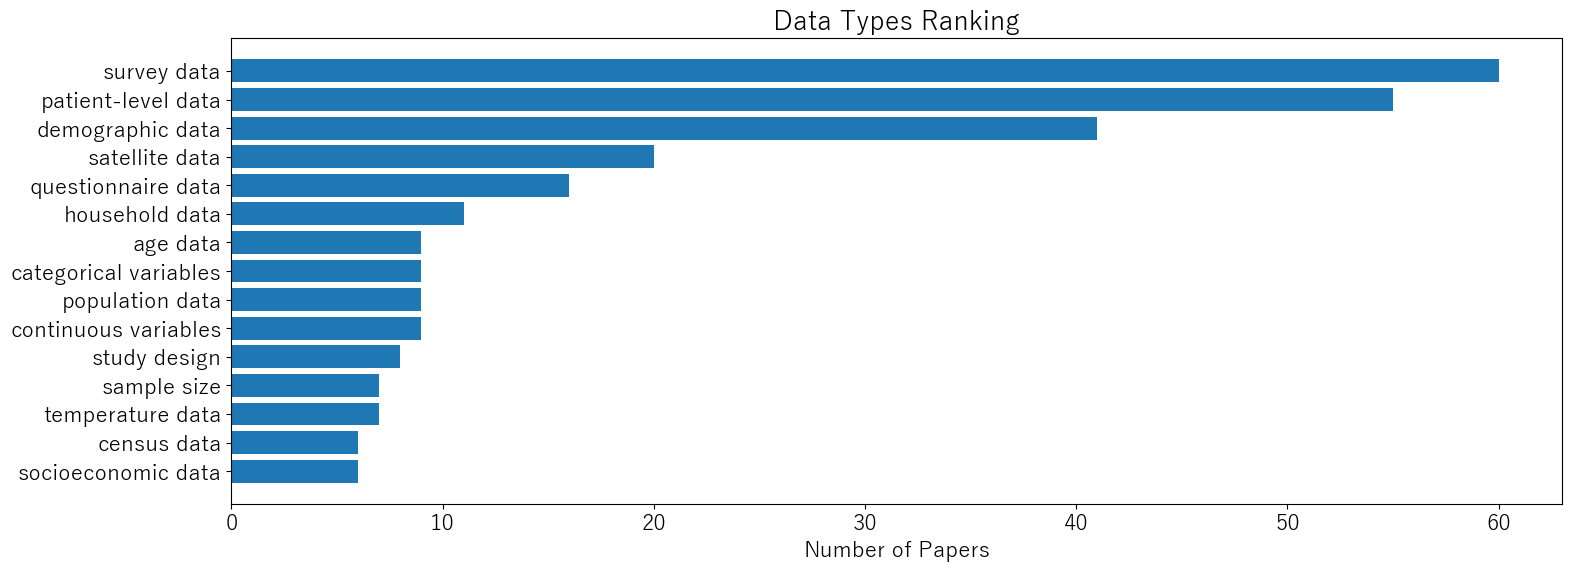

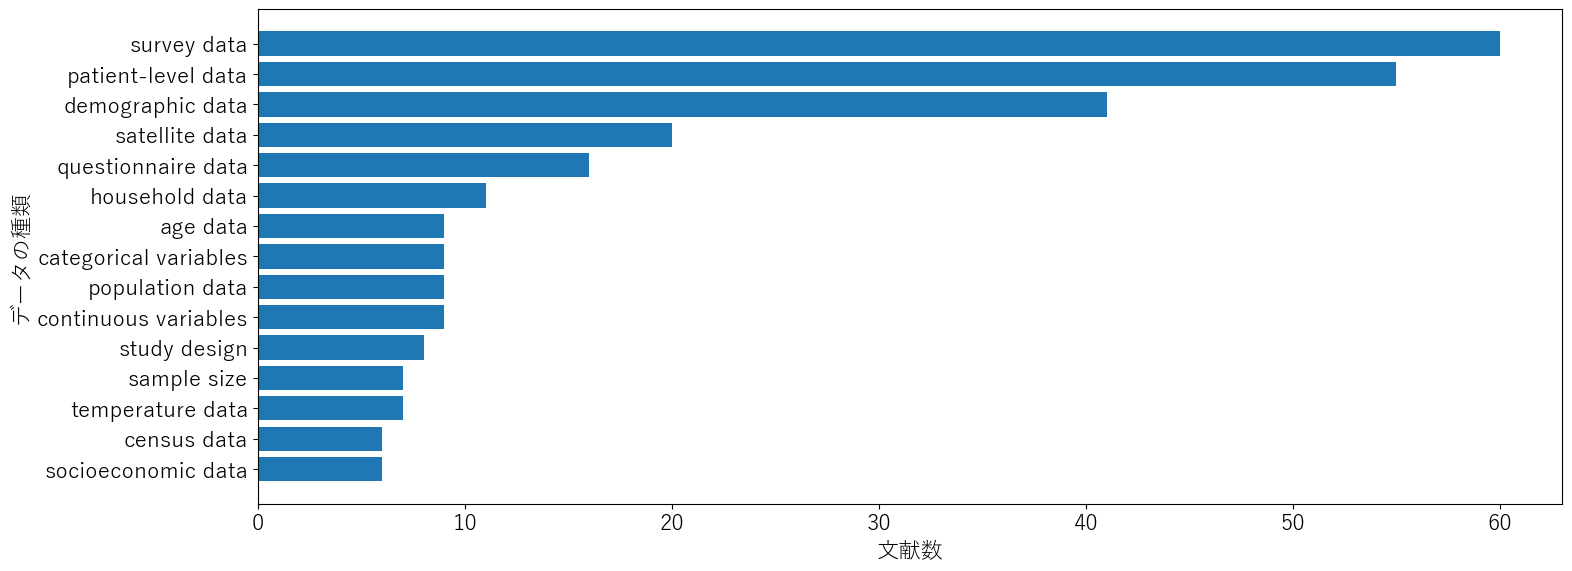

In [ ]:
# DataFrameに変換してランキング化
rank_df = pd.DataFrame(data_counts.items(), columns=['method', 'count'])
rank_df = rank_df.sort_values(by='count', ascending=False).reset_index(drop=True)
rank_df['rank'] = rank_df.index + 1

# 3. プロット
plt.rcParams['font.size']=20
plt.rcParams['font.family']='Yu Gothic'

plt.figure(figsize=(16, 6))
plt.barh(rank_df['method'][0:15], rank_df['count'][0:15])
plt.gca().invert_yaxis()
plt.xlabel('Number of Papers')
plt.ylabel('Data Types')
plt.tight_layout()
plt.savefig('../imgs/llm_data_types_ranking_en.png')
plt.show()

plt.figure(figsize=(16, 6))
plt.barh(rank_df['method'][0:15], rank_df['count'][0:15])
plt.gca().invert_yaxis()
plt.xlabel('文献数')
plt.ylabel('データの種類')
plt.tight_layout()
plt.savefig('../imgs/llm_data_types_ranking_jp.png')
plt.show()

# 4. 保存
rank_df.to_csv('../data/metadata/data_ranking.csv', index=False, encoding='utf-8-sig')